In [1]:
### Making the dataset long format for analysis

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_data_onetask.csv")
df_long = pd.melt(
    df,
    id_vars=['subject', 'cnd'],
    value_vars=['d1', 'd5'],
    var_name='score_time',
    value_name='score'
)

subjects_per_group = df_long.groupby('cnd')['subject'].nunique()
print(subjects_per_group)

cnd
Control         10
Full            10
Reactivation    10
Name: subject, dtype: int64


In [2]:
### for later if we want to compare d2 and d5 scores in the full training group

df = pd.read_csv("all_data_twotasks.csv")
df_long_day2 = pd.melt(
    df,
    id_vars=['subject', 'cnd'],
    value_vars=['d2', 'd5'],
    var_name='score_time',
    value_name='score'
)

In [3]:
### Perform one-way ANOVA on day 1 scores to see if there are significant differences between conditions
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Filter data for day 1 scores only
df_d1 = df_long[df_long['score_time'] == 'd1']

model = ols('score ~ cnd', data=df_d1).fit()
anova_table = sm.stats.anova_lm(model, typ=2) 

print(anova_table)


                sum_sq    df         F    PR(>F)
cnd         112.540941   2.0  0.018814  0.981374
Residual  80752.761706  27.0       NaN       NaN


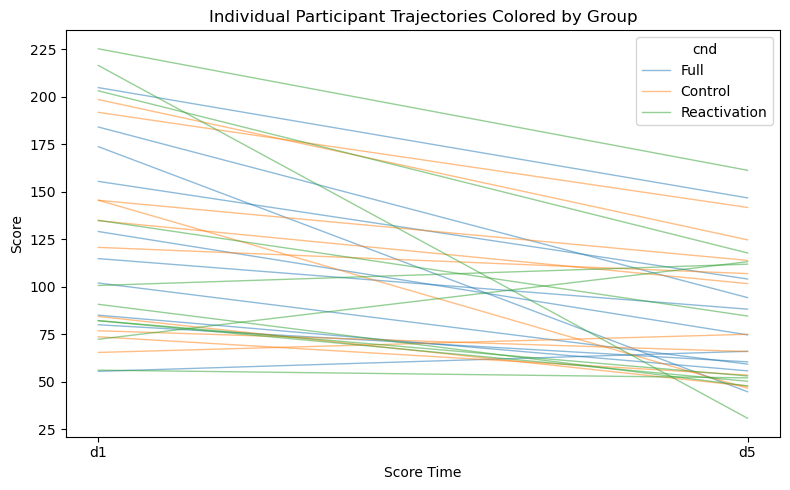

In [4]:
### checking individual participant trajectories colored by group
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_long,
    x="score_time",
    y="score",
    hue="cnd",         
    units="subject",    
    estimator=None,     
    alpha=0.5,
    lw=1
)

plt.title("Individual Participant Trajectories Colored by Group")
plt.xlabel("Score Time")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


In [5]:
# Checking learning in each group
df_control = df_long[df_long['cnd'] == 'Control'].copy()

# Fit the model on Control only
model = smf.mixedlm(
    "score ~ score_time",
    data=df_control,
    groups=df_control["subject"],
    re_formula="~score_time"
)
result = model.fit()
print(result.summary())

# Subset to Control group only
df_full = df_long[df_long['cnd'] == 'Full'].copy()

model_simple = smf.mixedlm(
    "score ~ score_time",
    data=df_full,
    groups=df_full["subject"]
)  # no re_formula

result_simple = model_simple.fit(method='lbfgs')
print(result_simple.summary())


# Subset to Control group only
df_reac = df_long[df_long['cnd'] == 'Reactivation'].copy()

# Fit the model on Control only
model = smf.mixedlm(
    "score ~ score_time",
    data=df_reac,
    groups=df_reac["subject"]
)
result = model.fit()
print(result.summary())


                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        score   
No. Observations:        20             Method:                    REML    
No. Groups:              10             Scale:                     361.3707
Min. group size:         2              Log-Likelihood:            -90.7890
Max. group size:         2              Converged:                 Yes     
Mean group size:         2.0                                               
---------------------------------------------------------------------------
                              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                     123.675   15.270  8.099 0.000  93.746 153.604
score_time[T.d5]              -35.983   10.042 -3.583 0.000 -55.664 -16.301
Group Var                    1970.459                                      
Group x score_time[T.d5] Cov -7

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    score   
No. Observations:    20         Method:                REML    
No. Groups:          10         Scale:                 815.3618
Min. group size:     2          Log-Likelihood:        -95.8240
Max. group size:     2          Converged:             Yes     
Mean group size:     2.0                                       
---------------------------------------------------------------
                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         135.362   16.243  8.334 0.000 103.527 167.197
score_time[T.d5]  -42.501   12.770 -3.328 0.001 -67.530 -17.473
Group Var        1822.861   52.077                             



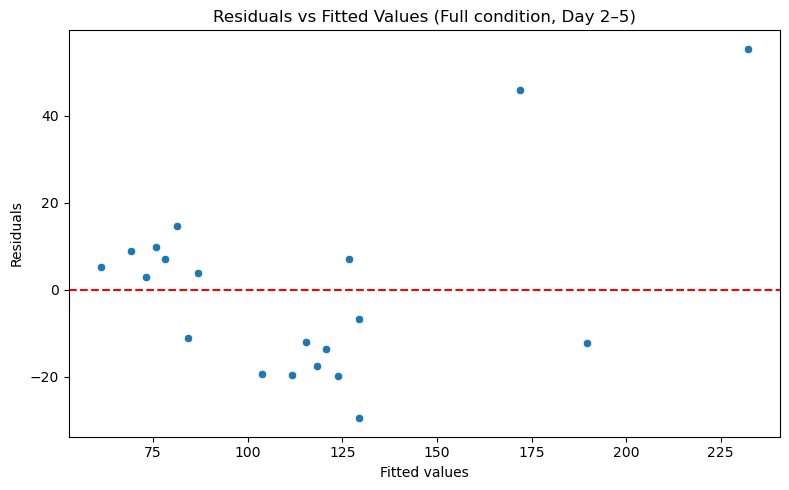

In [6]:
# Did day 2 to day 5 scores change in the Full group?
df_full = df_long_day2[(df_long_day2['cnd'] == 'Full') & (df_long_day2['score_time'].isin(['d2', 'd5']))]
df_full = df_full.copy()
subjects_per_group = df_long.groupby('cnd', observed=True)['subject'].nunique()


# Fit LMM: random intercept and slope for Time per subject
model = smf.mixedlm(
    "score ~ score_time",
    data=df_full,
    groups=df_full["subject"],
)
result = model.fit()
print(result.summary())

# Add fitted and residuals to dataframe
df_full['fitted'] = result.fittedvalues
df_full['residuals'] = result.resid

# Plot residuals vs fitted values
plt.figure(figsize=(8, 5))
sns.scatterplot(x='fitted', y='residuals', data=df_full)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Full condition, Day 2–5)')
plt.tight_layout()
plt.show()



                       Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          score    
No. Observations:            60               Method:                      REML     
No. Groups:                  30               Scale:                       762.7988 
Min. group size:             2                Log-Likelihood:              -283.3674
Max. group size:             2                Converged:                   Yes      
Mean group size:             2.0                                                    
------------------------------------------------------------------------------------
                                       Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------
Intercept                              123.675   17.294  7.151 0.000  89.779 157.571
score_time[T.d5]                       -35.983   14.539 -2.475 0.013 -64.479  -7.487
cnd[

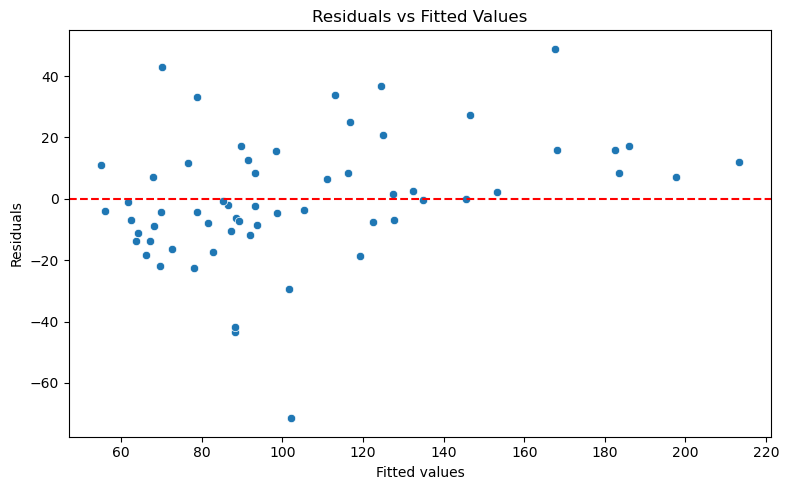

In [7]:
# Set 'Full' as the reference group for cnd and make LMM
df_long['cnd'] = pd.Categorical(df_long['cnd'], categories=['Control', 'Full','Reactivation'])

# Fit linear mixed model: random intercept and random slope for score_time per subject
model = smf.mixedlm(
    "score ~ score_time * cnd",
    data=df_long,
    groups=df_long["subject"],
    re_formula="~score_time"
)
result = model.fit()
print(result.summary())

# Get fitted values and residuals
df_long['fitted'] = result.fittedvalues
df_long['residuals'] = result.resid

# Plot residuals vs fitted values
plt.figure(figsize=(8, 5))
sns.scatterplot(x='fitted', y='residuals', data=df_long)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.tight_layout()
plt.show()



                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         score    
No. Observations:         60              Method:                     REML     
No. Groups:               30              Scale:                      762.7988 
Min. group size:          2               Log-Likelihood:             -283.3674
Max. group size:          2               Converged:                  Yes      
Mean group size:          2.0                                                  
-------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                         126.358   17.294  7.306 0.000  92.462 160.254
score_time[T.d5]                  -44.152   14.539 -3.037 0.002 -72.648 -15.656
cnd[T.Control]                     -2.683   24.458 -0.110 0.9

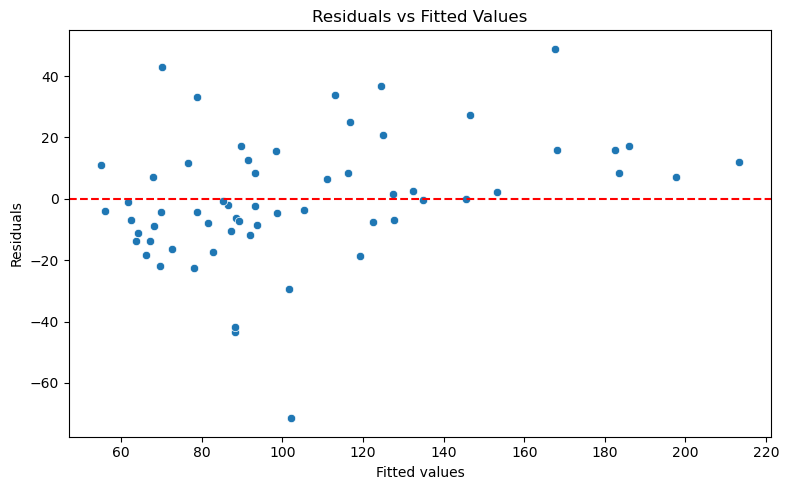

In [8]:
# Set 'Full' as the reference group to see if Full and Reactivation differ
df_long['cnd'] = pd.Categorical(df_long['cnd'], categories=['Reactivation','Control', 'Full'])

# Fit linear mixed model: random intercept and random slope for score_time per subject
model = smf.mixedlm(
    "score ~ score_time * cnd",
    data=df_long,
    groups=df_long["subject"],
    re_formula="~score_time"
)
result = model.fit()
print(result.summary())

# Get fitted values and residuals
df_long['fitted'] = result.fittedvalues
df_long['residuals'] = result.resid

# Plot residuals vs fitted values
plt.figure(figsize=(8, 5))
sns.scatterplot(x='fitted', y='residuals', data=df_long)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.tight_layout()
plt.show()



In [10]:
### Correlation between d5 scores and the percentage correction on 15 reminder trials in Reactivation group
from scipy.stats import pearsonr

df = pd.read_csv("all_data_onetask.csv")
df_reactivation = df[df['cnd'] == 'Reactivation'].dropna(subset=['d5', 'reac_corr'])
corr_coef, p_value = pearsonr(df_reactivation['d5'], df_reactivation['reac_corr'])

print(f"Correlation between d5 scores and reac_corr in Reactivation group:")
print(f"r = {corr_coef:.3f}, p = {p_value:.3f}")


Correlation between d5 scores and reac_corr in Reactivation group:
r = 0.076, p = 0.834


Now looking at the transfer data

In [11]:
### Making the dataset now for transfer analysis

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_data_onetask.csv")

df_long_transfer = pd.melt(
    df,
    id_vars=['subject', 'cnd'],
    value_vars=['d5', 'Transfer'],
    var_name='score_time',
    value_name='score'
)

subjects_per_group = df_long.groupby('cnd', observed=True)['subject'].nunique()
print(subjects_per_group)

cnd
Reactivation    10
Control         10
Full            10
Name: subject, dtype: int64


In [15]:
# Identify subjects with missing Transfer
subjects_with_missing_transfer = df.loc[df['Transfer'].isna(), 'subject'].unique()

# Exclude all data for those subjects from df_long
df_long_clean = df_long_transfer[~df_long['subject'].isin(subjects_with_missing_transfer)].copy()
df_long_clean['cnd'] = pd.Categorical(df_long_clean['cnd'], categories=['Reactivation', 'Full', 'Control'])
subjects_per_cnd = df_long_clean.groupby('cnd', observed=True)['subject'].nunique()
print("Number of subjects per condition after excluding missing Transfer:")
# Ensure score_time is a categorical variable with the right order: d5 as reference
df_long_clean['score_time'] = pd.Categorical(df_long_clean['score_time'], categories=['d5', 'Transfer'])

# Filter only Reactivation condition

# Ensure score_time has the correct order
df_long_clean['score_time'] = pd.Categorical(df_long_clean['score_time'], categories=['d5', 'Transfer'])

# Fit model: change over time in Reactivation group only (random intercept per subject)
model = smf.mixedlm(
    "score ~ score_time",
    data=df_long_clean,
    groups=df_long_clean["subject"],
)
result = model.fit()
print(result.summary())


Number of subjects per condition after excluding missing Transfer:
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    score     
No. Observations:     18         Method:                REML      
No. Groups:           9          Scale:                 11891.1258
Min. group size:      2          Log-Likelihood:        -99.9686  
Max. group size:      2          Converged:             Yes       
Mean group size:      2.0                                         
------------------------------------------------------------------
                        Coef.  Std.Err.   z   P>|z| [0.025  0.975]
------------------------------------------------------------------
Intercept               90.230   36.349 2.482 0.013 18.987 161.472
score_time[T.Transfer] 124.699   51.405 2.426 0.015 23.947 225.451
Group Var                0.000   42.853                           



/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
